In [1]:
!pip install kneed kneebow pandas==0.24.2

In [2]:
from google.colab import drive
#drive.flush_and_unmount()
#drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd "/content/drive/My Drive/WORK/ML/Neurosteer/ML2020"

/content/drive/My Drive/WORK/ML/Neurosteer/ML2020


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14906057727504799922
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 743700985591181181
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6103536046397465363
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11880146697201215561
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [5]:
!rm -rf ml2020
!git clone https://hershkoy@bitbucket.org/hershkoy/ml2020.git

Cloning into 'ml2020'...
remote: Counting objects: 323, done.
remote: Compressing objects: 100% (320/320), done.
remote: Total 323 (delta 149), reused 0 (delta 0)
Receiving objects: 100% (323/323), 1.55 MiB | 2.55 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [0]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
import umap.umap_ as umap
import tensorflow as tf
from skimage.measure import block_reduce

import os
import sys
sys.path.insert(0,os.path.join(os.getcwd(),"ml2020/code/lib"))


import Vizualization
import ClusterFinder
import skRPCA

from itertools import combinations


In [7]:
infile = open('data/sleep_data/df_features_test_env_unlabeled.pkl','rb')
obj = pickle.load(infile)
infile.close()

ind = obj.index
ind.names

recs = ind.get_level_values(0)

sessionNames_list = obj.index.levels[0]
print(sessionNames_list)

Index(['2019-08-17-19-17-01', '2019-08-17-22-49-11', '2019-08-18-20-07-11',
       '2019-08-18-20-38-22', '2019-08-19-20-44-45', '2019-08-22-19-16-00',
       '2019-08-27-20-56-05'],
      dtype='object', name='sessionName')


In [8]:
with tf.device("/gpu:0"):

    idx1=  6

    sessionName1 = sessionNames_list[idx1]
    samples1 = obj.loc[sessionName1].get_values()
    timestamp1 = obj.index.levels[2][:len(samples1)]

    print(sessionName1,samples1.shape, timestamp1.shape)


    #%%

    rpca_components = 121
    pca_components = 10

    pipe = Pipeline(steps=[
        #('scalar', StandardScaler()),
        ('rpca', skRPCA.skRPCA(n_components=rpca_components)),
        ('pca', PCA(n_components=pca_components)),
        ('model',GaussianMixture(n_components=5,covariance_type='full'))
    ])

    model = ClusterFinder.ClusterFinder(pipe)

    vizualization = Vizualization.Vizualization()

    model.fit(samples1)


    #%%

    X_pca =model.just_transforms(samples1) 


    reducer  = MDS(n_components=2, verbose=1, n_jobs=4,dissimilarity="euclidean") 
    reducer_results = reducer.fit_transform(X_pca[::4])

    clf = DBSCAN(eps=0.4,min_samples=20)
    c = clf.fit_predict(reducer_results)

    df = pd.DataFrame()
    df['2d-one'] = reducer_results[:,0]
    df['2d-two'] = reducer_results[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="2d-one", y="2d-two",
        hue = c,
        palette=sns.color_palette("hls", len(np.unique(c))),
        data=df,
        legend="full",
        alpha=0.3
    )
    plt.title("Session ID-"+str(idx1)+" "+sessionName1+" RPCA="+str(rpca_components)+"+PCA="+str(pca_components)+"+MDS ")

    plt.savefig("images/s"+str(idx1)+"_RPCA="+str(rpca_components)+" _PCA="+str(pca_components)+"+MDS.png")
    plt.close()

2019-08-27-20-56-05 (23778, 121) (23778,)
iteration: 1, error: 0.03863129981771255
iteration: 2, error: 8.590929903947722e-06
121 (121, 121) (23778, 121)


Text(0.5, 1.0, 'Session ID-6 2019-08-27-20-56-05 RPCA=121+PCA=10+MDS ')

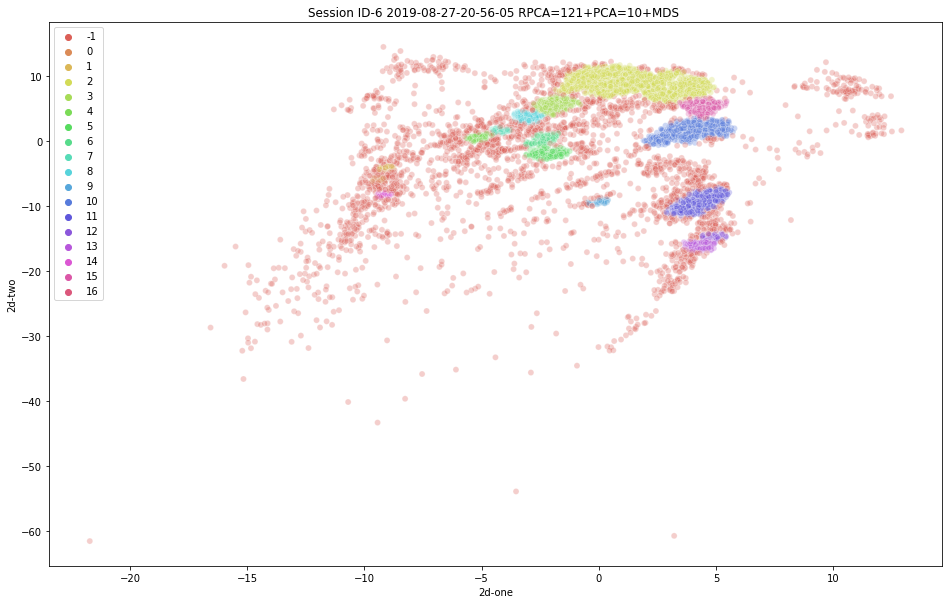

In [11]:
plt.figure(figsize=(16,10))
sns.scatterplot(
        x="2d-one", y="2d-two",
        hue = c,
        palette=sns.color_palette("hls", len(np.unique(c))),
        data=df,
        legend="full",
        alpha=0.3
    )
plt.title("Session ID-"+str(idx1)+" "+sessionName1+" RPCA="+str(rpca_components)+"+PCA="+str(pca_components)+"+MDS ")

Text(0.5, 1.0, 'Session ID-6 2019-08-27-20-56-05 RPCA=121+PCA=10+MDS \n clusters concentration (width related to number of points per cluster)')

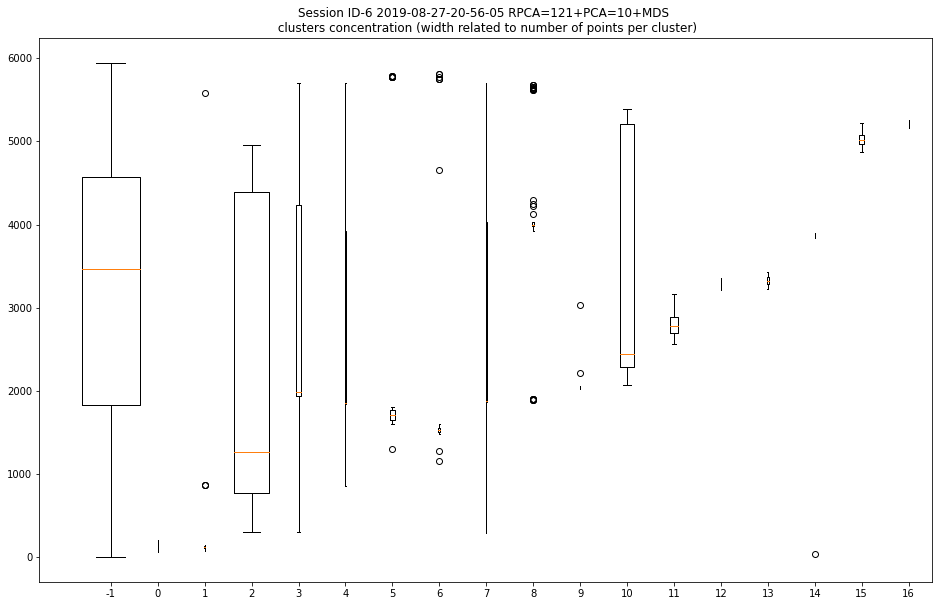

In [13]:
data=[]
lengths=[]
for c1 in np.unique(c):
    data.append(np.where(c==c1)[0])
    lengths.append(len(np.where(c==c1)[0]))
lengths = np.array(lengths)

fig = plt.figure(figsize=(16,10))
plt.boxplot(data,
            labels = np.arange(-1,len(np.unique(c))-1),
            widths = lengths/2000
            )
plt.title("Session ID-"+str(idx1)+" "+sessionName1+" RPCA="+str(rpca_components)+"+PCA="+str(pca_components)+"+MDS \n clusters concentration (width related to number of points per cluster)")


Text(0.5, 1.0, 'Session ID-6 2019-08-27-20-56-05 RPCA=121 PCA=10+MDS (downsampled) \n Possible Hypnogram - labels may not be in the correct order')

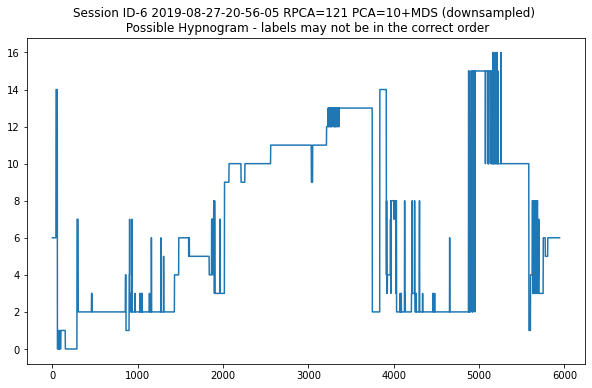

In [17]:
# plot hypnogram (-1 = noise)
for i in np.arange(len(c)):
    if c[i]==-1:
        c[i] = c[i-1]
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(c)),c)
plt.title("Session ID-"+str(idx1)+" "+sessionName1+" RPCA="+str(rpca_components)+" PCA="+str(pca_components)+"+MDS (downsampled) \n Possible Hypnogram - labels may not be in the correct order")

2019-08-27-20-56-05 (23778, 121) (23778,)
iteration: 1, error: 0.03863129981771255
iteration: 2, error: 8.590929903947722e-06
121 (121, 121) (23778, 121)


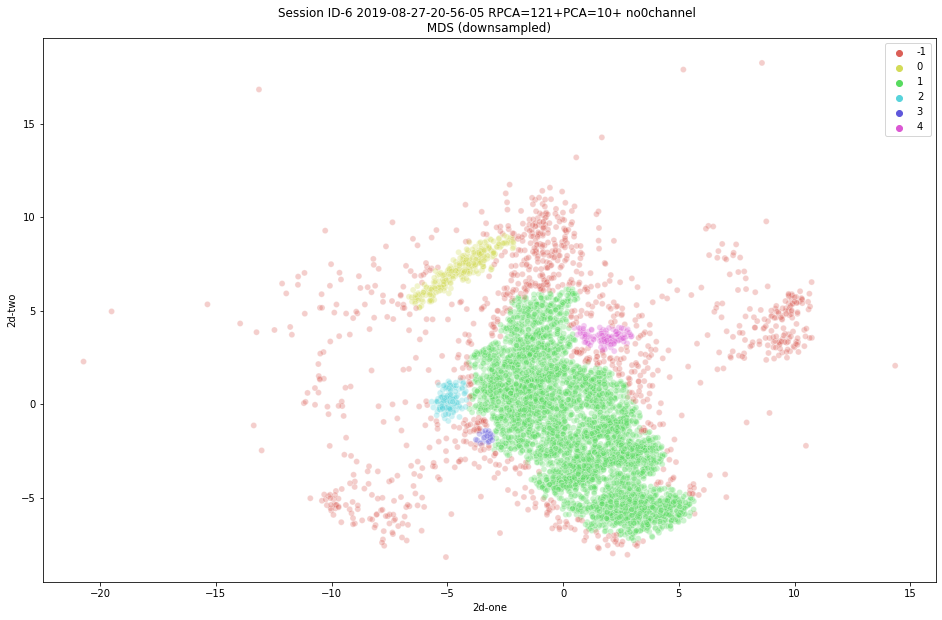

In [18]:
with tf.device("/gpu:0"):

    idx1=  6
    downsample = 4

    sessionName1 = sessionNames_list[idx1]
    samples1 = obj.loc[sessionName1].get_values()
    timestamp1 = obj.index.levels[2][:len(samples1)]

    print(sessionName1,samples1.shape, timestamp1.shape)


    #%%

    rpca_components = 121
    pca_components = 10

    pipe = Pipeline(steps=[
        #('scalar', StandardScaler()),
        ('rpca', skRPCA.skRPCA(n_components=rpca_components)),
        ('pca', PCA(n_components=pca_components)),
        ('model',GaussianMixture(n_components=5,covariance_type='full'))
    ])

    model = ClusterFinder.ClusterFinder(pipe)

    vizualization = Vizualization.Vizualization()

    model.fit(samples1)


    #%%

    X_pca =model.just_transforms(samples1) 


    reducer  = MDS(n_components=2, verbose=1, n_jobs=4,dissimilarity="euclidean") 
    reducer_results = reducer.fit_transform(X_pca[::downsample,1:])

    clf = DBSCAN(eps=0.4,min_samples=20)
    c = clf.fit_predict(reducer_results)

    df = pd.DataFrame()
    df['2d-one'] = reducer_results[:,0]
    df['2d-two'] = reducer_results[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="2d-one", y="2d-two",
        hue = c,
        palette=sns.color_palette("hls", len(np.unique(c))),
        data=df,
        legend="full",
        alpha=0.3
    )
    plt.title("Session ID-"+str(idx1)+" "+sessionName1+" RPCA="+str(rpca_components)+"+PCA="+str(pca_components)+"+ no0channel \n MDS (downsampled) ")

    plt.savefig("images/s"+str(idx1)+"_RPCA="+str(rpca_components)+" _PCA="+str(pca_components)+"_no0channel_MDS.png")


Text(0.5, 1.0, 'Session ID-6 2019-08-27-20-56-05 RPCA=121+PCA=10+MDS \n clusters concentration (width related to number of points per cluster)')

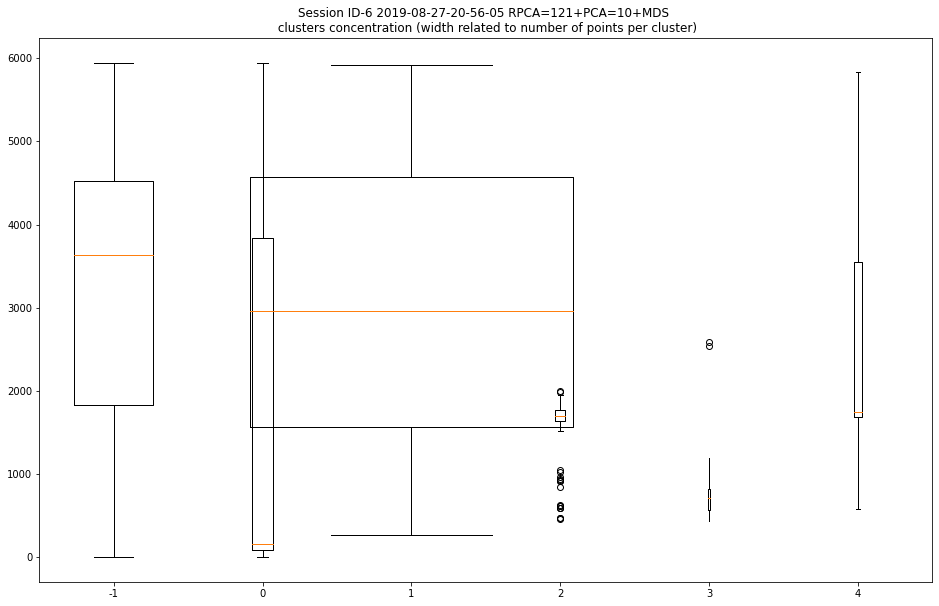

In [19]:
data=[]
lengths=[]
for c1 in np.unique(c):
    data.append(np.where(c==c1)[0])
    lengths.append(len(np.where(c==c1)[0]))
lengths = np.array(lengths)

fig = plt.figure(figsize=(16,10))
plt.boxplot(data,
            labels = np.arange(-1,len(np.unique(c))-1),
            widths = lengths/2000
            )
plt.title("Session ID-"+str(idx1)+" "+sessionName1+" RPCA="+str(rpca_components)+"+PCA="+str(pca_components)+"+MDS \n clusters concentration (width related to number of points per cluster)")


Text(0.5, 1.0, 'Session ID-6 2019-08-27-20-56-05 RPCA=121 PCA=10+MDS (downsampled) \n Possible Hypnogram - labels may not be in the correct order')

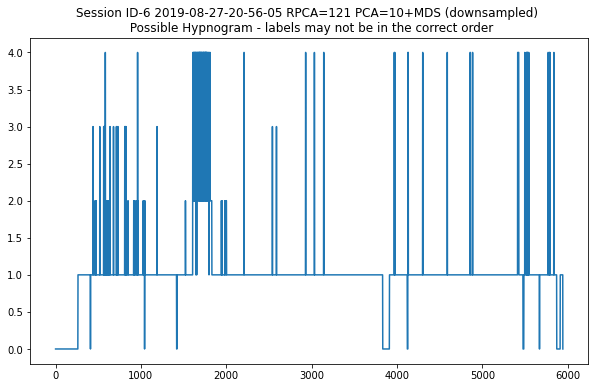

In [20]:
# plot hypnogram (-1 = noise)
for i in np.arange(len(c)):
    if c[i]==-1:
        c[i] = c[i-1]
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(c)),c)
plt.title("Session ID-"+str(idx1)+" "+sessionName1+" RPCA="+str(rpca_components)+" PCA="+str(pca_components)+"+MDS (downsampled) \n Possible Hypnogram - labels may not be in the correct order")